In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from math import floor

In [2]:
df= pd.read_csv(r"C:\Users\91758\Downloads\Time Series\Train.csv")
df.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [3]:
df.shape

(18288, 3)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18288 entries, 0 to 18287
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        18288 non-null  int64 
 1   Datetime  18288 non-null  object
 2   Count     18288 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 428.8+ KB


In [5]:
print(df['Datetime'].min())
print(df['Datetime'].max())

01-01-2013 00:00
31-12-2013 23:00


In [6]:
train= df.drop(df[df['Datetime']<'2012-08-01 00:00'].index)
train= df.drop(df[df['Datetime']>'2014-02-09 00:00'].index)

In [7]:
df['Datetime']= pd.to_datetime(df['Datetime'])

In [8]:
df.set_index('Datetime', inplace= True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18288 entries, 2012-08-25 00:00:00 to 2014-09-25 23:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ID      18288 non-null  int64
 1   Count   18288 non-null  int64
dtypes: int64(2)
memory usage: 428.6 KB


In [10]:
df.head()

,ID,Count
Datetime,,
2012-08-25 00:00:00,0,8
2012-08-25 01:00:00,1,2
2012-08-25 02:00:00,2,6
2012-08-25 03:00:00,3,2
2012-08-25 04:00:00,4,2


Stationary: if its statistical properties such as mean, variance remain constant over time. Intuitively, if a TS has a particular behaviour over time , there is a high probability that it will follow the same in future. Criteria for stationary series:
<ul>
<li>Constant mean
<li>Constant variable
<li>Autocovariance that does not depend on time</ul>

In [11]:
s=floor(2*df.shape[0]/3)
s

12192

In [12]:
valid = df[s:]
df = df[:s]

In [13]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(24).mean() # 24 hours on each day
    rolstd = timeseries.rolling(24).std()

    #Plot rolling statistics:
    plt.figure(figsize=(30,12))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

C:\Users\91758\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


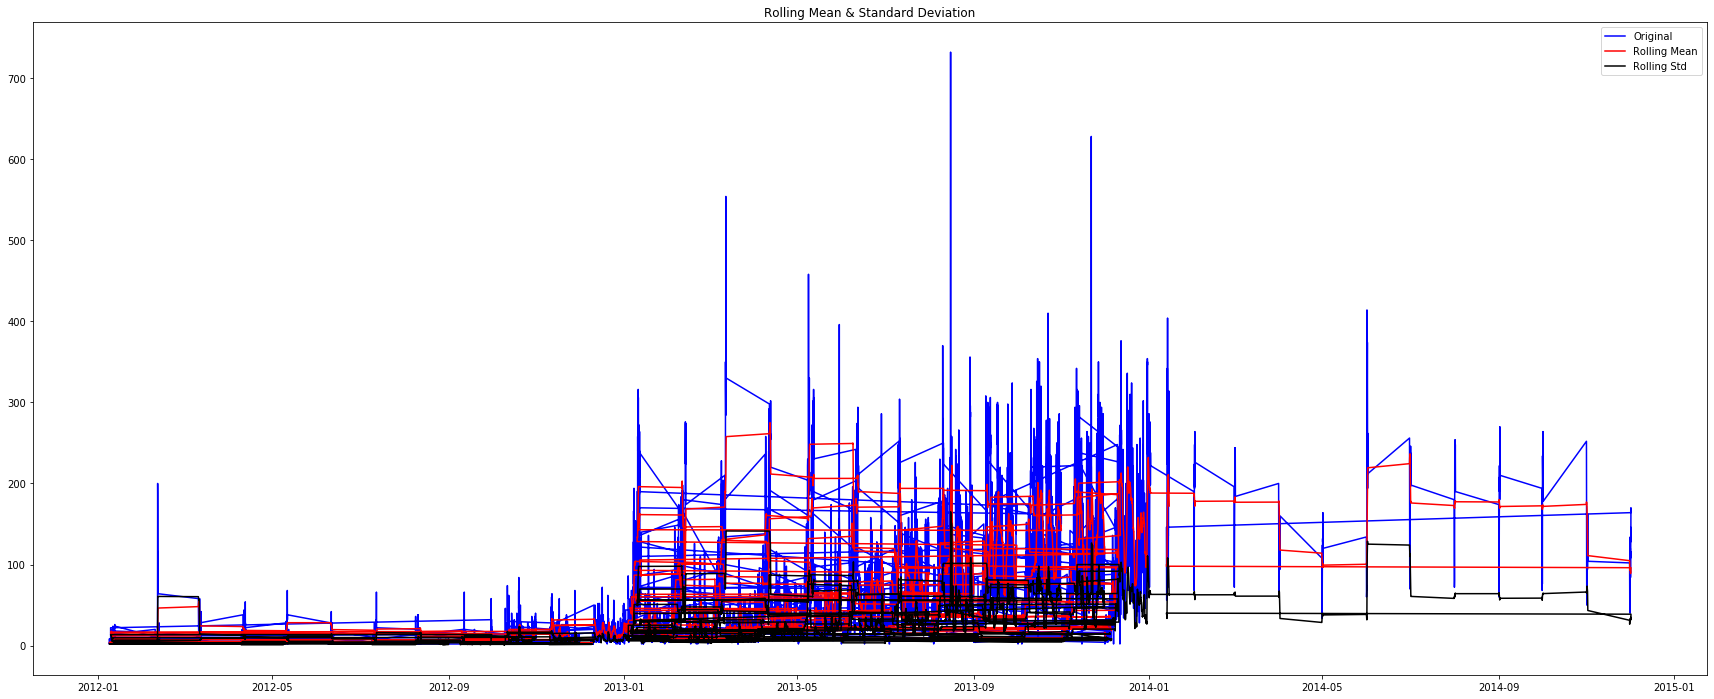

Results of Dickey-Fuller Test:
Test Statistic                -5.876353e+00
p-value                        3.152826e-07
#Lags Used                     4.000000e+01
Number of Observations Used    1.215100e+04
Critical Value (1%)           -3.430888e+00
Critical Value (5%)           -2.861778e+00
Critical Value (10%)          -2.566897e+00
dtype: float64


In [14]:
test_stationarity(df['Count'])

Evethough the Statistic Test show that the data is stationary ( Test Statistic < Critical Values), we still can see an increasing trend in the data. Therefore, we will try to make the data more stationary firstly. We need to remove two properties from the data: trend and seasonality.

#### Trend removing

Trend: data varying mean over time. For example: the number of the value can increase or decrease over time. Estimating and Eliminating Trend techniques: Transformation: for example, for increasing trend, we can apply transformation which penalizes higher values more than smaller ones. For example: log, square root,... Some ways to estimate and remove the trend:
<ul>
<li>Aggregation: taking average of time period likw monthly/weekly
<li>Smoothing: taking rolling average
<li>Polynomial fitting: fit a regression model</ul>

##### Smoothing

Computing the rolling average of the data. Here we take the window size in 24 based on the fact that each day has 24 hours

In [15]:
train_log = np.log(df['Count'])

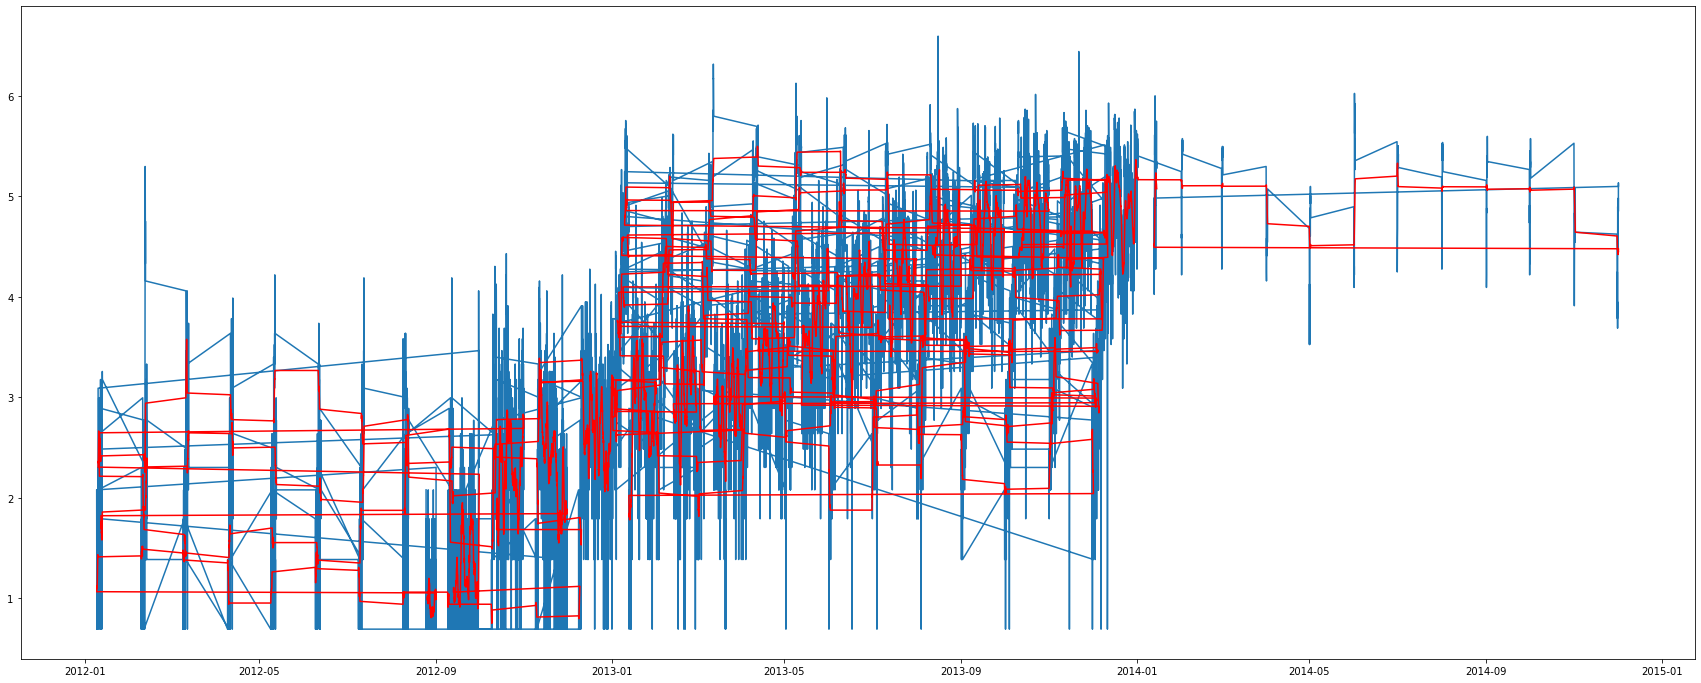

In [16]:
moving_avg = train_log.rolling(24).mean()
plt.figure(figsize=(30,12))
plt.plot(train_log)
plt.plot(moving_avg, color = 'red')

In [17]:
#removing the increasing trend 
train_log_moving_avg_diff = train_log - moving_avg

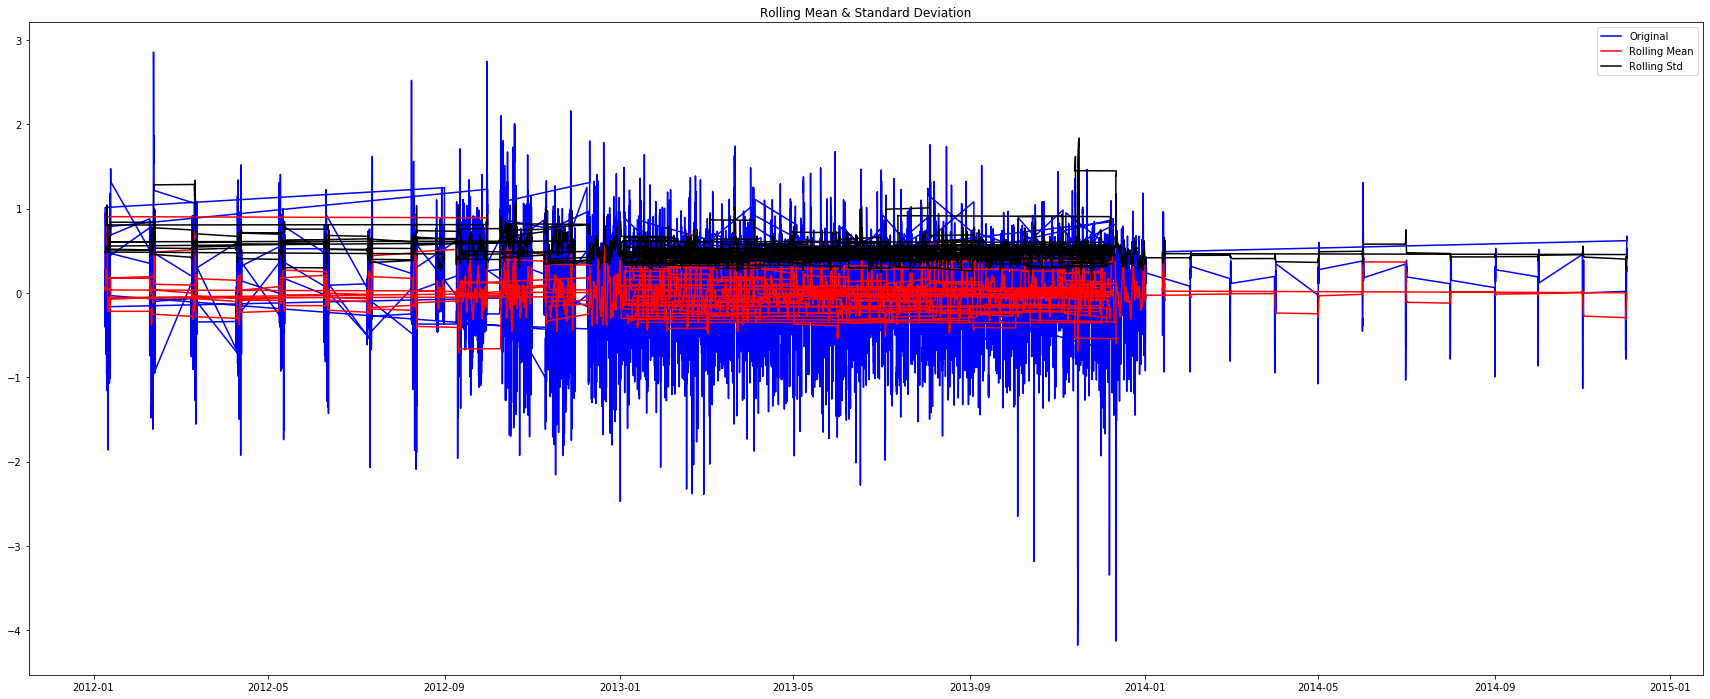

Results of Dickey-Fuller Test:
Test Statistic                   -22.511449
p-value                            0.000000
#Lags Used                        40.000000
Number of Observations Used    12128.000000
Critical Value (1%)               -3.430889
Critical Value (5%)               -2.861778
Critical Value (10%)              -2.566897
dtype: float64


In [18]:
# Since we are taking the average of 24 values, rolling mean is not defined for the first 23 values. (NaN)
train_log_moving_avg_diff.dropna(inplace = True)
test_stationarity(train_log_moving_avg_diff)

The Test Statistic values is way smaller than the critical value so we can be confident that the data is stationary now. A disadvantage of smoothing: the time period must strictly predicted. For example, in case of stock price, it may not be easy to come up with a time frame.



### Exponentially weighted moving average

In [ ]:
expwighted_avg = train_log.ewm(halflife=24)
plt.plot(train_log)
plt.plot(expwighted_avg, color='red')

In [ ]:
#removing the trend of increasing
train_log_ewma_diff = train_log - expwighted_avg
test_stationarity(train_log_ewma_diff)

### Seasonality remove
Seasonality: variations at specific time-frames. E.g: people have tendency to buy jacket in winters To remove the seasonality, we have two techniques:

<li>Differencing: taking the difference with a particular time lag
<li>Decomposition: modeling both trend and seasonality and removing them from the model

#### Differencing
Usually, non-stationary series can be corrected by just differencing.The idea behind differencing is that, if the original data series does not have constant properties over time, then the change from one period to another might.

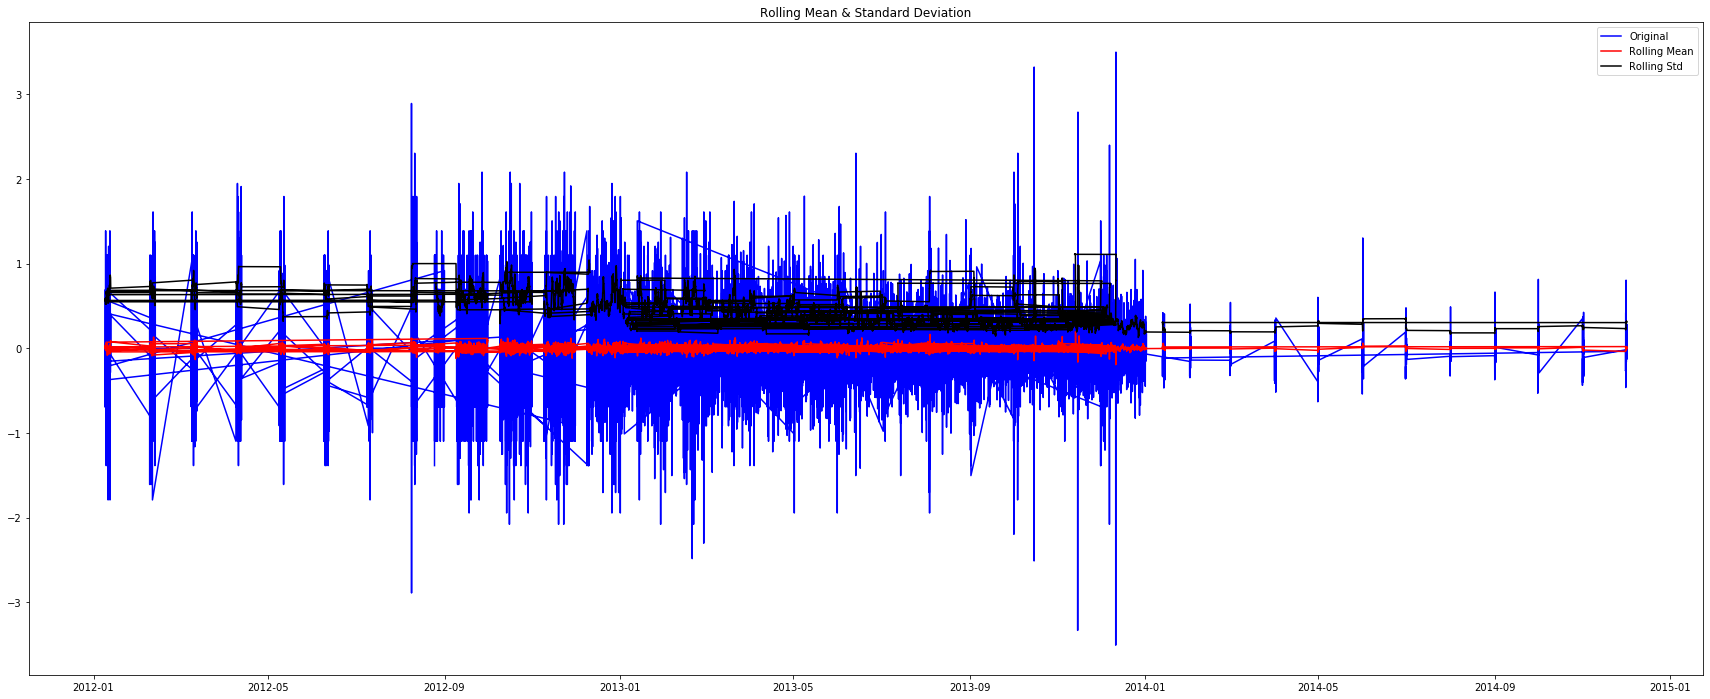

Results of Dickey-Fuller Test:
Test Statistic                   -21.888788
p-value                            0.000000
#Lags Used                        40.000000
Number of Observations Used    12150.000000
Critical Value (1%)               -3.430888
Critical Value (5%)               -2.861778
Critical Value (10%)              -2.566897
dtype: float64


In [19]:
train_log_diff = train_log - train_log.shift()
test_stationarity(train_log_diff.dropna())

In [20]:
train_log_diff.head()

Datetime
2012-08-25 00:00:00         NaN
2012-08-25 01:00:00   -1.386294
2012-08-25 02:00:00    1.098612
2012-08-25 03:00:00   -1.098612
2012-08-25 04:00:00    0.000000
Name: Count, dtype: float64

### Decomposition
In decomposition, trend and seasonality are treated separatedly. Let's recall the definitions:
<br>
<li>Trend: The increasing or decreasing value in the series.
<li>Seasonality: The repeating short-term cycle in the series.
<li>Residual: The random variation in the series.

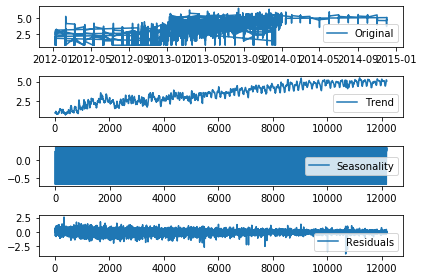

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(pd.DataFrame(train_log).Count.values, freq = 24)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(train_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

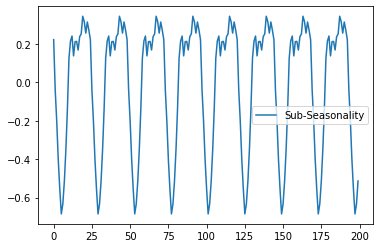

In [22]:
#A closer look at the seasonality 
plt.plot(seasonal[:200],label='Sub-Seasonality')
plt.legend(loc='best')

Here we can see that the trend, seasonality are separated out from data and we can model the residuals. The trend line show a gradual increasing trend, while the seasonality show a constant trend in counter. Lets check stationarity of residuals, which should have no pattern and normally distributed:

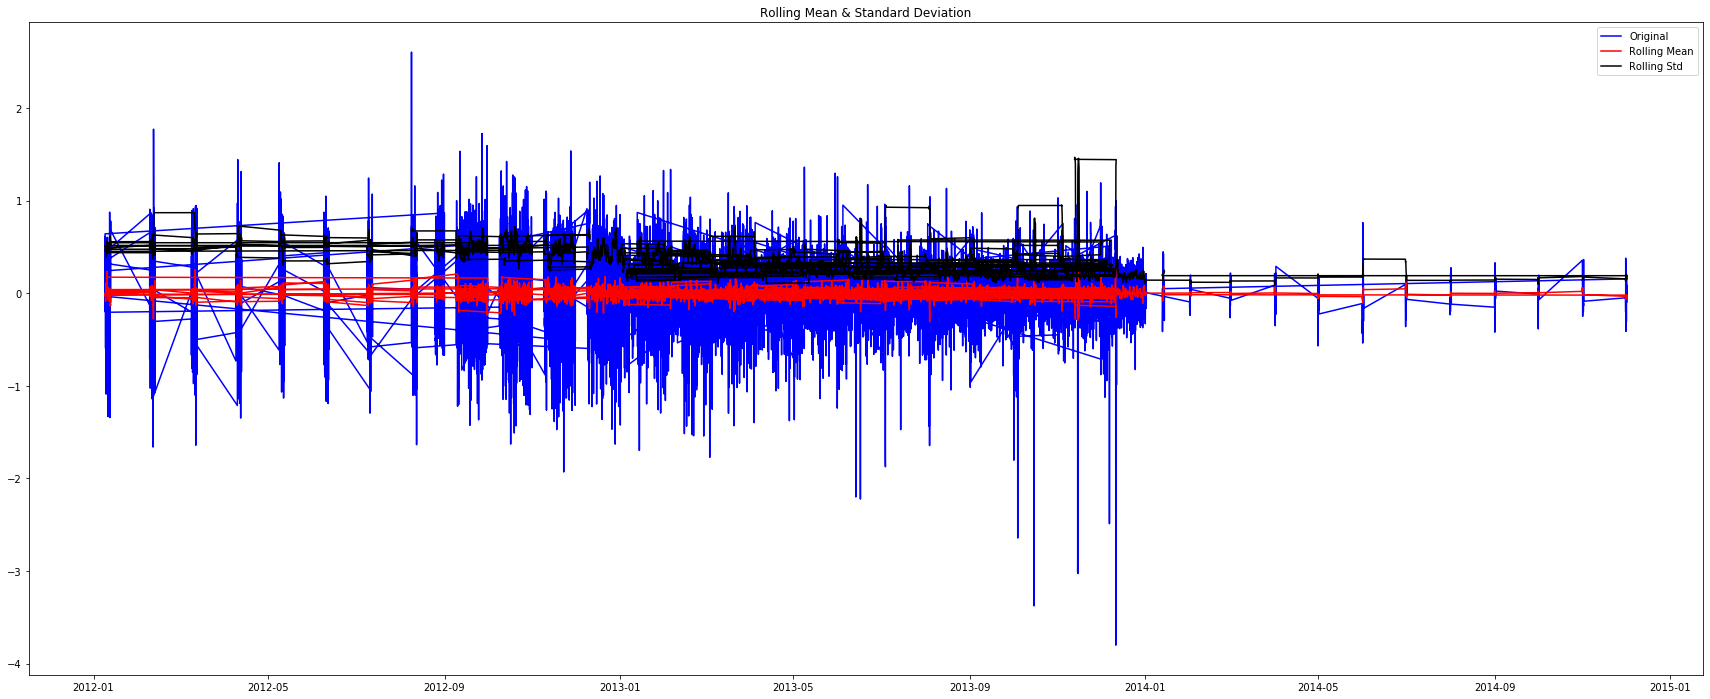

Results of Dickey-Fuller Test:
Test Statistic                   -28.597113
p-value                            0.000000
#Lags Used                        39.000000
Number of Observations Used    12128.000000
Critical Value (1%)               -3.430889
Critical Value (5%)               -2.861778
Critical Value (10%)              -2.566897
dtype: float64


In [23]:
train_log_decompose = pd.DataFrame(residual)
train_log_decompose['date'] = train_log.index
train_log_decompose.set_index('date', inplace = True)
train_log_decompose.dropna(inplace=True)
test_stationarity(train_log_decompose[0])

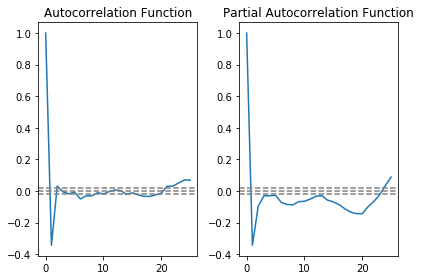

In [24]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(train_log_diff.dropna(), nlags=25)
lag_pacf = pacf(train_log_diff.dropna(), nlags=25, method='ols')
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

p – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=1. And we also can see there is a spike at p = 1

q – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=1. And we can also see there is a spike at q =1 

### AR Model

In [25]:
from statsmodels.tsa.arima_model import ARIMA

C:\Users\91758\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\91758\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS: nan')

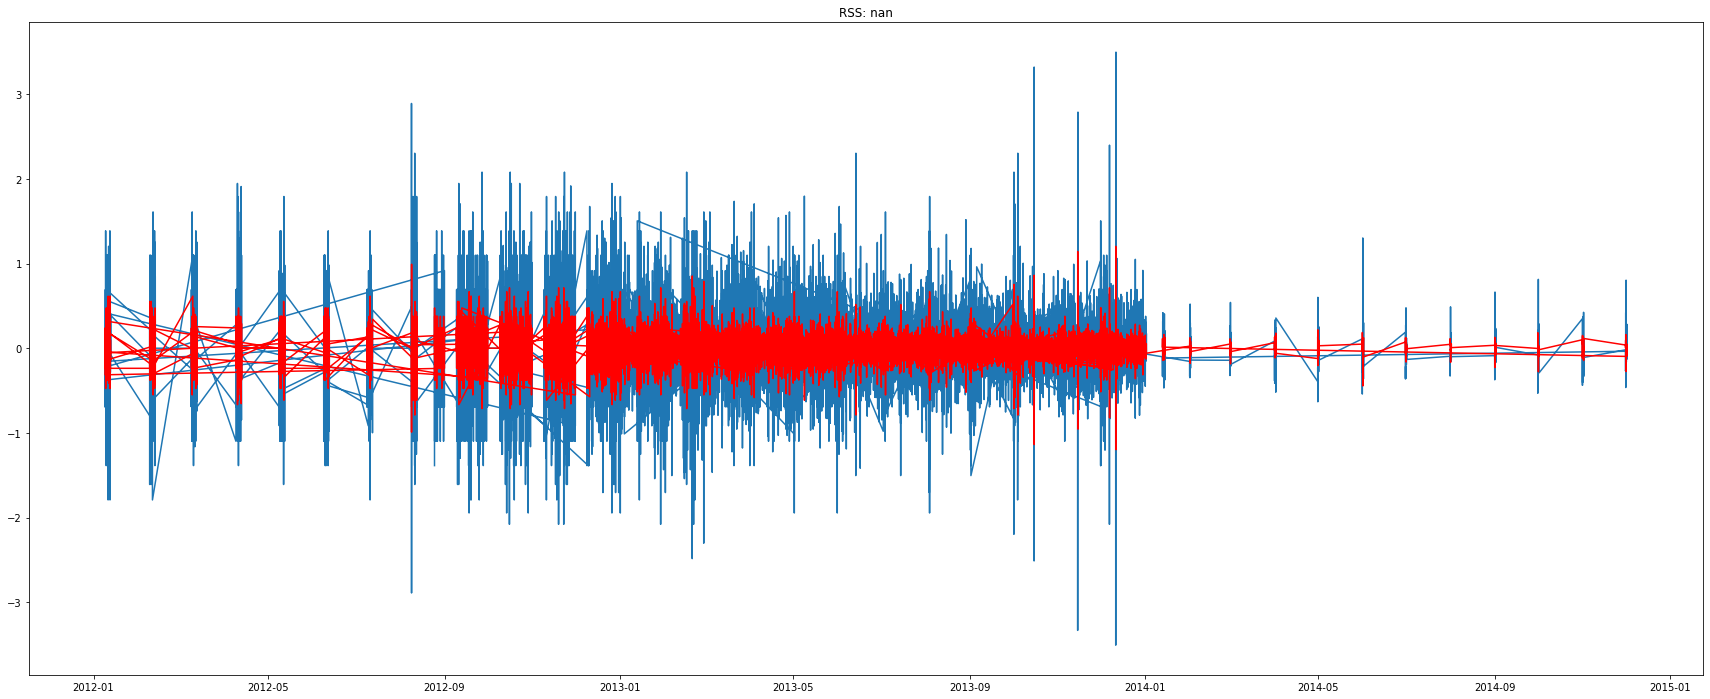

In [26]:
model = ARIMA(train_log, order=(1, 1, 0))  
results_AR = model.fit(disp=-1) 
plt.figure(figsize=(30,12))
plt.plot(train_log_diff.dropna())
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-train_log_diff)**2))

### MA Model

C:\Users\91758\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\91758\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS: nan')

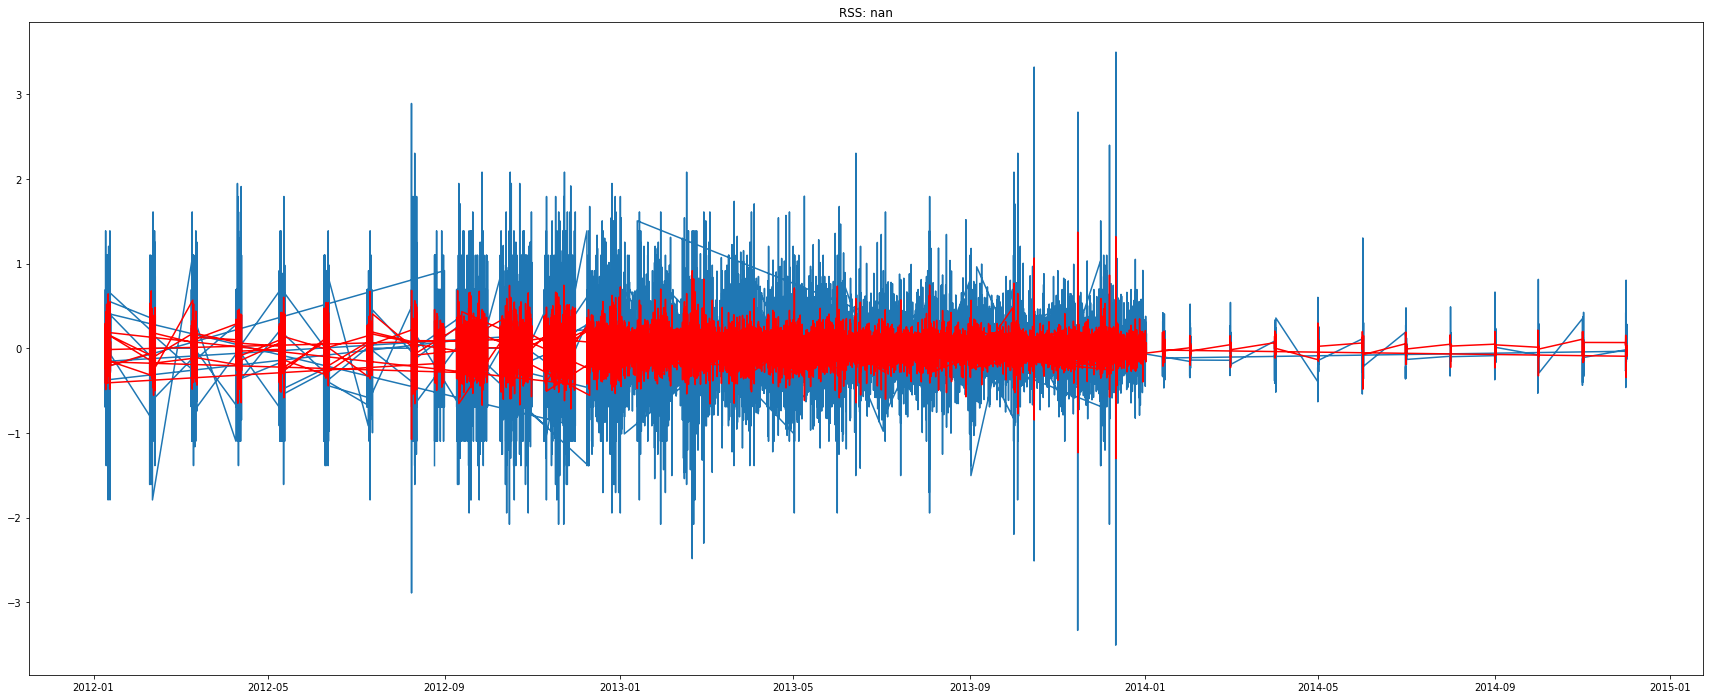

In [27]:
model = ARIMA(train_log, order=(0, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.figure(figsize=(30,12))
plt.plot(train_log_diff.dropna())
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-train_log_diff)**2))

C:\Users\91758\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\91758\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS: nan')

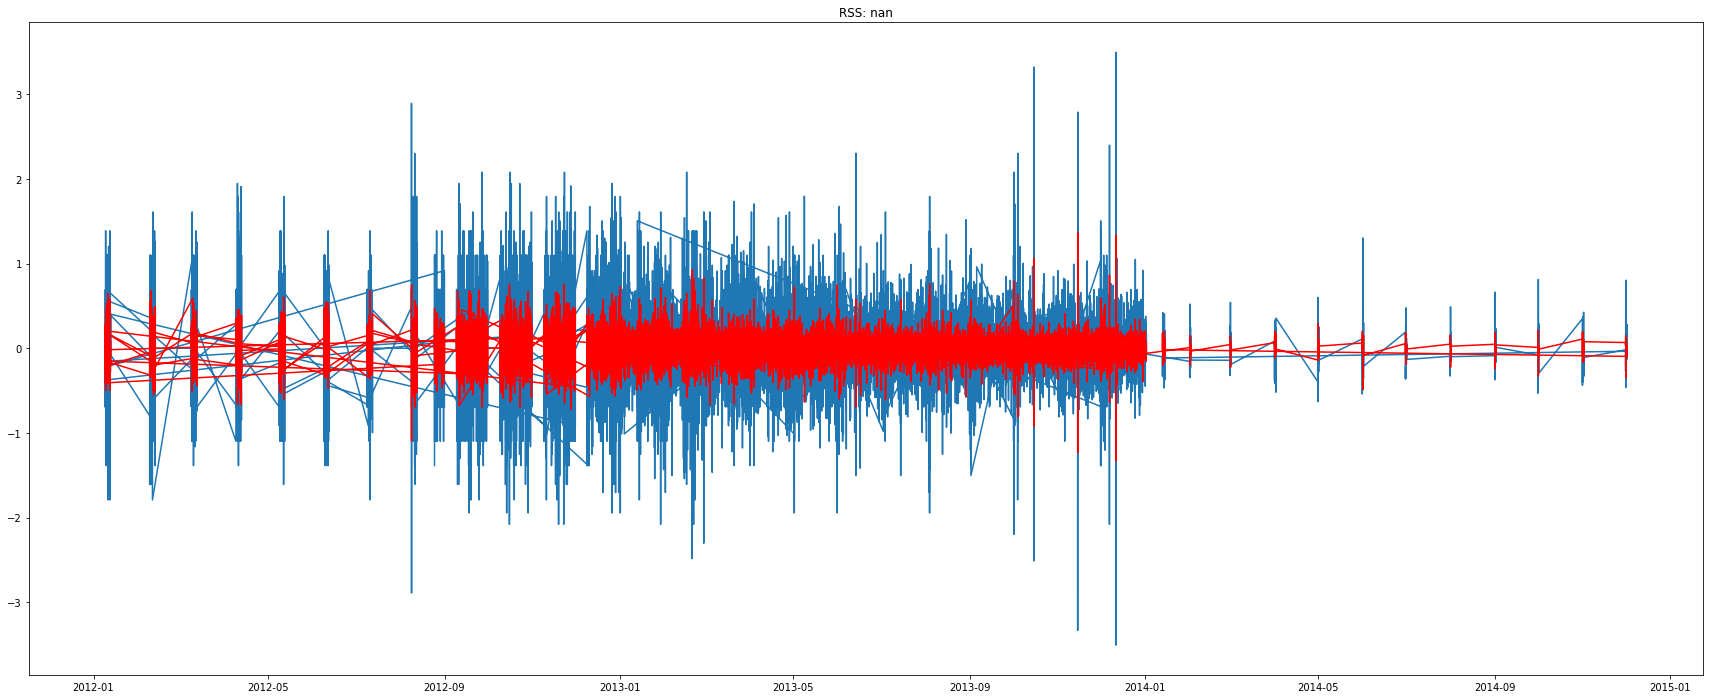

In [28]:
model = ARIMA(train_log, order=(1, 1, 1))  
results_MA = model.fit(disp=-1) 
plt.figure(figsize=(30,12))
plt.plot(train_log_diff.dropna())
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-train_log_diff)**2))

### Taking it back to the original scale

In [29]:
#bring the differencing back to the original scale
def check_prediction_diff(predict_diff, given_set):
    predict_diff= predict_diff.cumsum().shift().fillna(0)
    predict_base = pd.Series(np.ones(given_set.shape[0]) * np.log(given_set['Count'])[0], index = given_set.index)
    predict_log = predict_base.add(predict_diff,fill_value=0)
    predict = np.exp(predict_log)
    
    plt.figure(figsize=(30,12))
    plt.plot(given_set['Count'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))

In [30]:
def check_prediction_log(predict_log, given_set):
    predict = np.exp(predict_log)
    
    plt.figure(figsize=(30,12))
    plt.plot(given_set['Count'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))

In [31]:
model = ARIMA(train_log.dropna(), order=(0, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

Datetime
2012-08-25 01:00:00    0.000301
2012-08-25 02:00:00    0.457387
2012-08-25 03:00:00   -0.236847
2012-08-25 04:00:00    0.323821
2012-08-25 05:00:00    0.122123
dtype: float64


C:\Users\91758\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\91758\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


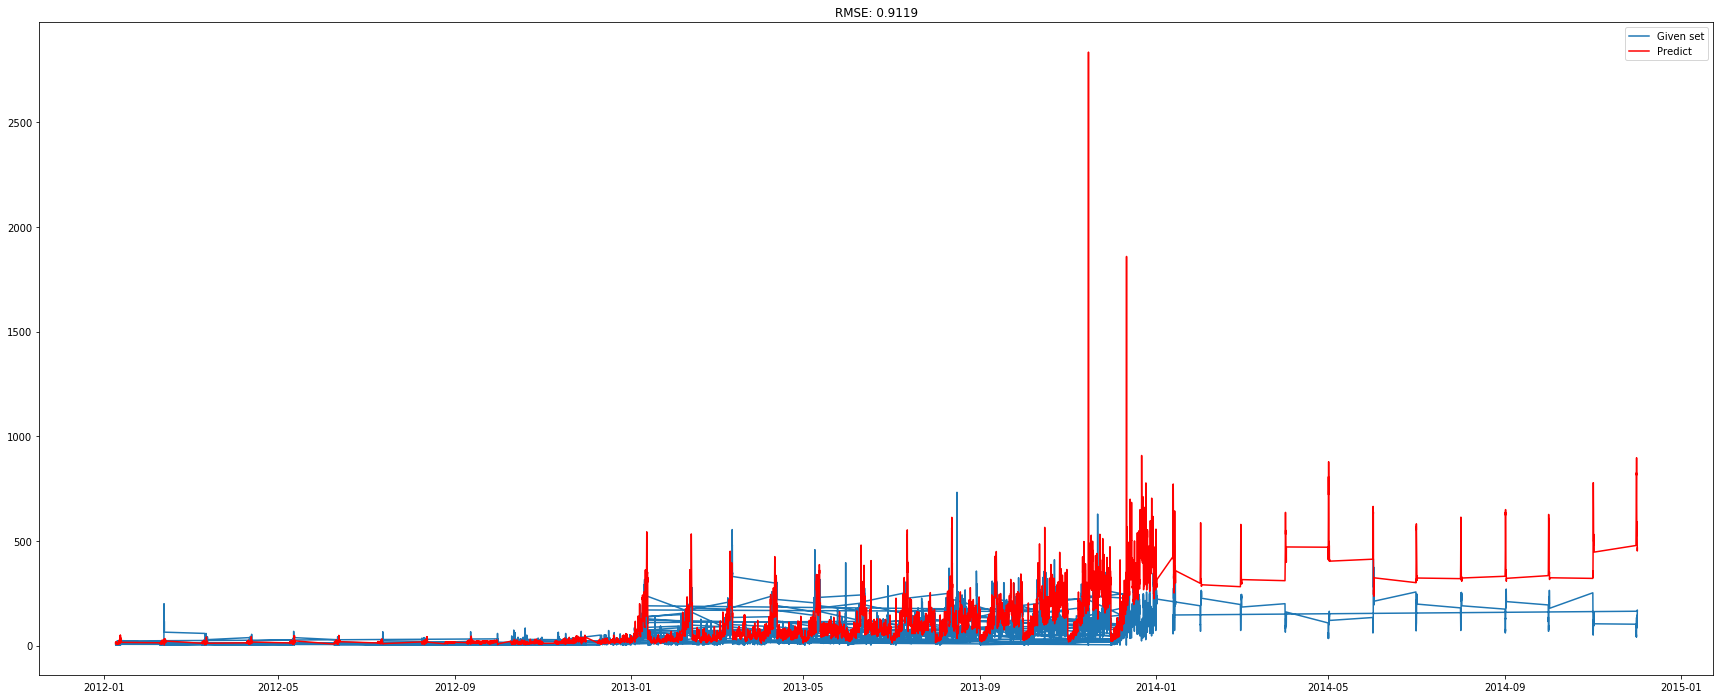

In [32]:
#check_prediction_diff(valid_predict_diff, valid)
check_prediction_diff(predictions_ARIMA_diff, df)

In [33]:
start = df.shape[0]
end = start + valid.shape[0]
valid_predict_diff = results_ARIMA.predict(start = start-1, end = end-2, typ = 'levels')
print (valid_predict_diff.head())
print (valid_predict_diff.tail())

12190    5.309126
12191    5.321121
12192    5.321421
12193    5.321722
12194    5.322023
dtype: float64
18281    7.152407
18282    7.152707
18283    7.153008
18284    7.153309
18285    7.153610
dtype: float64


C:\Users\91758\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:293: FutureWarning: RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead
  stop = base_index._start + (key + 1) * base_index._step
C:\Users\91758\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:293: FutureWarning: RangeIndex._step is deprecated and will be removed in a future version. Use RangeIndex.step instead
  stop = base_index._start + (key + 1) * base_index._step
C:\Users\91758\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:294: FutureWarning: RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead
  index = RangeIndex(start=base_index._start,
C:\Users\91758\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:296: FutureWarning: RangeIndex._step is deprecated and will be removed

In [34]:
predict = np.exp(valid_predict_diff)

In [35]:
predict.head()

12190    202.173424
12191    204.613024
12192    204.674561
12193    204.736117
12194    204.797691
dtype: float64

In [36]:
plt.figure(figsize=(30,12))
plt.plot(valid['Count'], label = "Given set")
plt.plot(valid_predict_diff, color = 'red', label = "Predict")
plt.legend(loc= 'best')

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x000002038D423AE8> (for post_execute):


ValueError: view limit minimum -23979.347916666673 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -23979.347916666673 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

In [37]:
df_test= pd.read_csv(r"C:\Users\91758\Downloads\Time Series\Test.csv")
df_test.head()

,ID,Datetime
0,18288,26-09-2014 00:00
1,18289,26-09-2014 01:00
2,18290,26-09-2014 02:00
3,18291,26-09-2014 03:00
4,18292,26-09-2014 04:00


In [44]:
df_test.tail()

,ID,Datetime
5107,23395,26-04-2015 19:00
5108,23396,26-04-2015 20:00
5109,23397,26-04-2015 21:00
5110,23398,26-04-2015 22:00
5111,23399,26-04-2015 23:00


In [38]:
df_test['Datetime']= pd.to_datetime(df_test['Datetime'])

In [39]:
df_test.shape

(5112, 2)

In [49]:
test= df_test
test= test.set_index(df_test['Datetime'])
test.drop(['ID','Datetime'], axis=1, inplace=True)

In [50]:
test.head()

""
Datetime
26-09-2014 00:00
26-09-2014 01:00
26-09-2014 02:00
26-09-2014 03:00
26-09-2014 04:00


In [51]:
test.shape

(5112, 0)

In [53]:
start = test.iloc[0]
end = test.iloc[-1]
#test_predict_diff = results_ARIMA.predict(start = start, end = end, typ = 'levels')
test_predict_diff = results_ARIMA.predict('26-09-2014 00:00', '26-04-2015 23:00')
print (test_predict_diff.head())
print (test_predict_diff.tail())

KeyError: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'